In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive




#Project Title:
Litter Object Detection Model (LODM)

#Project Members
Project Member: Nick Darrow | ndarr002@odu.edu | https://github.com/weebitjolly/CS-620-Intro-to-Data-Science-and-Analytics

#Primary Datasets
The project leverages a combination of labeled and unlabeled image datasets designed for object detection with Ultralytics YOLOv8. Each dataset includes training, validation, and testing splits, with annotations provided in JSON format. These images feature varied environmental conditions, providing a robust training base for the model.

#Dataset Sources:

https://universe.roboflow.com/trash-dataset-for-oriented-bounded-box/trash-detection-1fjjc/dataset/14

https://universe.roboflow.com/taco-ihjgk/yolov8-trash-detections-kgnug

https://universe.roboflow.com/yolov7-trash-detection-group/yolov7-trash-dataset-v5-05-04-2023

https://github.com/PUTvision/UAVVaste

Example Image:

### Examples of Data

![](https://drive.google.com/uc?export=view&id=1zX26GBuJuR82yIJMhUBX--UQy_Wybpou)

#Project Description
The Litter Object Detection Model (LODM) aims to address a key challenge for the City of Norfolk: the lack of a scalable, data-driven method for measuring and monitoring litter across the city. Currently, tracking relies heavily on manual surveys and volunteer-based programs, which are time- and resource-intensive.

To tackle this, the project developed a custom object detection model using YOLOv11, trained on thousands of annotated litter images across various environmental conditions. The model automates the identification and quantification of litter in photographs, with current performance metrics showing 84% precision and 64% recall.

A geospatial component will be added in future iterations to geocode images and create spatial heatmaps of litter concentrations across neighborhoods and public spaces. In parallel, a batch processing framework has been prototyped to handle large volumes of images efficiently, simulating real-world scalability. This framework is designed to run on local infrastructure with the long-term goal of securing cloud resources for broader deployment.

#Implementation Roadmap
Over several months, the project progressed through distinct phases:

Data Acquisition & Labeling: Collected and standardized multiple trash datasets from Roboflow and UAVVaste; relabeled images to match custom class definitions.

Model Training & Evaluation: Retrained a YOLOv8 model to improve precision/recall and adapt to urban Norfolk imagery.

Batch Processing Prototype: Built a prototype that simulates how the city could process large image sets at scale using local storage systems.

Infrastructure & Deployment Strategy: Developed plans for transitioning from cloud-hosted environments to locally run systems, with long-term visions for cloud licensing and mobile integration.

Stakeholder Engagement: Prepared to present results and next steps to city officials and sustainability partners, including discussion of a potential resident-facing mobile app for crowdsourced data collection and engagement.







# Design Decisions

### Target Audience
current proposed users will be employees at City of Norfolk. specifically we want to design this model so that employees working with litter can just ride around in cars and have the model run on those images in batches. this would be done under the batch processing framework done further down the line

### Tools and Technologies Used
We will be using [YOLOV8](https://arxiv.org/pdf/1506.02640)to run inference on images taken. This model has been first trained on a dataset of roughly 10,000 labeled images taken from [Roboflow Universe](https://universe.roboflow.com/) this illicited some lack luster results, and I hope to do some more hyper parameter tuning and dataset augmentations to improve mAP50, precision, and recall. This is accomplished through python notebooks utilizing **Google Colab** running on a hosted T4 GPU with plans to move it to a local GPU. Will update later as more softwares are used

### System Architecture and Implementation Details
Currently the model that I have runs on Google Colab. Most importantly will be to shift this towards a local framework and architecture, for posterity reasons. So the batch processing, cloud infrastructure and database infrastructure will be shifted away from google colab to something local.

### Overall Design and Core Features

To start I am testing on many different versions of YOLO (mostly V8 and V11, for more details visit [here](https://docs.ultralytics.com/)). Please look below for detailed code on the infrastructure I've set up to train the model, but follow along here for a summarized version. essentially we move prelabeled images into testing, training and validation sets each of these folders have to be split into image and labels folders. in the images folder you'll find the images and in the labels folder you will find a json file with labels and annotations referenced by the model later by a YAML file. The YAML file is used to define model configuration and directory location for the model to reference later. After this you can import your primary libraries, here you would import **ultralytics** which hosts all of the YOLO Models, you may need to download the specific model you want to use like I needed to do.

Now the model itself can vary depending on dataset size and content, # of classes, etc.  but as a baseline my current model runs on 50 epochs, with a standardized image size of 640x640 and a batch size of 16. you have to customize this based on the factors listed earlier. I plan on adding more training conditions and a better larger model which you can find more out about here: https://docs.ultralytics.com/modes/train/#key-features-of-train-mode


In [ ]:
import pandas as pd

urlLitterati = "https://data.norfolk.gov/resource/fq5y-c2yn.json"
urlIndex = "https://data.norfolk.gov/resource/nbz2-dgus.json"

dfLitterati = pd.read_json(urlLitterati)
dfIndex = pd.read_json(urlIndex)

print(dfLitterati.head())


   location_id            location_name  longitude   latitude  \
0        12938           Henneman Drive -76.221902  36.875986   
1        12939            Monmouth Lane -76.181192  36.851911   
2        12940  East Princess Anne Road -76.212753  36.874911   
3        12941  East Princess Anne Road -76.232639  36.866883   
4        12942           Bristol Avenue -76.193833  36.843277   

   distance_spring_2022  distance_summer_2022  distance_fall_2022  \
0                 269.0                 212.0               248.0   
1                 274.0                 286.0               321.0   
2                 261.0                 302.0               246.0   
3                 243.0                 303.0                 NaN   
4                 142.0                 209.0               246.0   

   number_of_objects_of_litter  number_of_objects_of_litter_1  \
0                          8.0                           10.0   
1                         32.0                           21.0   

In [ ]:
# this dataset does not have lat long measures so were going to hard code them in so that we can
#visualize geographic distributions easier and more accurately
import pandas as pd
import re

# Load from API
url = "https://data.norfolk.gov/resource/nbz2-dgus.json"
df = pd.read_json(url)

# Normalize column
df.rename(columns={"Ward-Route": "ward_route"}, inplace=True)

# Normalize 'Ward 1-1a' → 'Ward 1 Route 1'
def normalize_ward_route(raw):
    match = re.match(r"Ward (\d+)-(\d+)", str(raw))
    if match:
        ward, route = match.groups()
        return f"Ward {ward} Route {route}"
    return None

df['normalized_route'] = df['ward_route'].apply(normalize_ward_route)

# Coordinates mapping
coords = {
    "Ward 1 Route 1": (36.8893, -76.3125), "Ward 1 Route 2": (36.8927, -76.3088),
    "Ward 1 Route 3": (36.9038, -76.3035), "Ward 1 Route 4": (36.9485, -76.2702),
    "Ward 1 Route 5": (36.9527, -76.2718), "Ward 1 Route 6": (36.9550, -76.2720),
    "Ward 1 Route 7": (36.9604, -76.2735), "Ward 1 Route 8": (36.9623, -76.2752),
    "Ward 1 Route 9": (36.9240, -76.2490), "Ward 1 Route 10": (36.9305, -76.2664),
    "Ward 1 Route 11": (36.9089, -76.2710), "Ward 1 Route 12": (36.9115, -76.2754),
    "Ward 2 Route 1": (36.9175, -76.2495), "Ward 2 Route 2": (36.9170, -76.2460),
    "Ward 2 Route 3": (36.9161, -76.2766), "Ward 2 Route 4": (36.9150, -76.2535),
    "Ward 2 Route 5": (36.8730, -76.2915), "Ward 2 Route 6": (36.8858, -76.2996),
    "Ward 2 Route 7": (36.8784, -76.2997), "Ward 2 Route 8": (36.8685, -76.2945),
    "Ward 2 Route 9": (36.8620, -76.2880), "Ward 2 Route 10": (36.8505, -76.2880),
    "Ward 2 Route 11": (36.8550, -76.2870), "Ward 2 Route 12": (36.8665, -76.2872),
    "Ward 3 Route 1": (36.9200, -76.2380), "Ward 3 Route 2": (36.9175, -76.2360),
    "Ward 3 Route 3": (36.9070, -76.2325), "Ward 3 Route 4": (36.8845, -76.2310),
    "Ward 3 Route 5": (36.8753, -76.2353), "Ward 3 Route 6": (36.8677, -76.2355),
    "Ward 3 Route 7": (36.8530, -76.2402), "Ward 3 Route 8": (36.8505, -76.2380),
    "Ward 3 Route 9": (36.8610, -76.2390), "Ward 3 Route 10": (36.8635, -76.2425),
    "Ward 3 Route 11": (36.8655, -76.2460), "Ward 3 Route 12": (36.8623, -76.2480),
    "Ward 4 Route 1": (36.8570, -76.2735), "Ward 4 Route 2": (36.8500, -76.2752),
    "Ward 4 Route 3": (36.8407, -76.2737), "Ward 4 Route 4": (36.8374, -76.2565),
    "Ward 4 Route 5": (36.8495, -76.2670), "Ward 4 Route 6": (36.8655, -76.2220),
    "Ward 4 Route 7": (36.8670, -76.2165), "Ward 4 Route 8": (36.8662, -76.2130),
    "Ward 4 Route 9": (36.8674, -76.2100), "Ward 4 Route 10": (36.8665, -76.2055),
    "Ward 4 Route 11": (36.8695, -76.2030), "Ward 4 Route 12": (36.8720, -76.2010),
    "Ward 5 Route 1": (36.8755, -76.2000), "Ward 5 Route 2": (36.8780, -76.1980),
    "Ward 5 Route 3": (36.9130, -76.1780), "Ward 5 Route 4": (36.9155, -76.1772),
    "Ward 5 Route 5": (36.9160, -76.1830), "Ward 5 Route 6": (36.9168, -76.1890),
    "Ward 5 Route 7": (36.9095, -76.1990), "Ward 5 Route 8": (36.9090, -76.2020),
    "Ward 5 Route 9": (36.9100, -76.2045), "Ward 5 Route 10": (36.9130, -76.2080),
    "Ward 5 Route 11": (36.9145, -76.2110), "Ward 5 Route 12": (36.9155, -76.2150),
}

# Map coordinates
df['approx_lat'] = df['normalized_route'].map(lambda x: coords.get(x, (None, None))[0])
df['approx_lon'] = df['normalized_route'].map(lambda x: coords.get(x, (None, None))[1])

# Display result
print(df.head(30))


      ward_route  _2010  _2011  _2012  _2013  _2014  _2015  _2016  _2017  \
0      Ward 1-1a    1.0   1.00   1.00    1.0    1.0   1.00    1.0   1.00   
1      Ward 1-1b    1.0   1.00   1.00    1.0    1.0   1.00    1.0   1.00   
2      Ward 1-1c    1.0   1.00   1.00    1.0    1.0   1.00    1.0   2.00   
3      Ward 1-1d    1.0   2.00   1.00    1.0    1.0   1.00    1.0    NaN   
4      Ward 1-1e    1.0   1.00   1.00    1.0    1.0    NaN    1.0    NaN   
5      Ward 1-1f    NaN   2.00   1.00    NaN    NaN    NaN    NaN    NaN   
6   Ward 1-1 Avg    1.0   1.33   1.00    1.0    1.0   1.00    1.0   1.33   
7      Ward 1-2a    2.0   1.00   2.00    1.0    2.0   2.00    1.0   2.00   
8      Ward 1-2b    2.0   1.00   2.00    2.0    2.0   2.00    1.0   2.00   
9      Ward 1-2c    2.0   2.00   2.00    1.5    1.0   2.00    1.0   3.00   
10     Ward 1-2d    2.0   2.00   1.00    1.0    2.0   2.00    1.0    NaN   
11     Ward 1-2e    3.0   2.00   2.00    2.0    2.0    NaN    1.0    NaN   
12     Ward 

In [ ]:
# Step 1: Get all columns that look like "_2010" to "_2019"
year_cols = [col for col in df.columns if col.startswith('_20') and col[1:].isdigit() and 2010 <= int(col[1:]) <= 2019]

# Step 2: Melt to long format
df_long = df.melt(
    id_vars=['ward_route', 'approx_lat', 'approx_lon'],
    value_vars=year_cols,
    var_name='year',
    value_name='litter_index'
)

# Step 3: Strip the underscore from 'year'
df_long['year'] = df_long['year'].str[1:]

print(df_long.head())


  ward_route  approx_lat  approx_lon  year  litter_index
0  Ward 1-1a     36.8893    -76.3125  2010           1.0
1  Ward 1-1b     36.8893    -76.3125  2010           1.0
2  Ward 1-1c     36.8893    -76.3125  2010           1.0
3  Ward 1-1d     36.8893    -76.3125  2010           1.0
4  Ward 1-1e     36.8893    -76.3125  2010           1.0


In [ ]:
df_long["litter_index"] = df_long["litter_index"].fillna(df_long["litter_index"].mean())



In [ ]:
# Only keep rows where 'ward_route' contains 'Avg'
df_avg = df[df['ward_route'].str.contains("Avg", case=False, na=False)]


In [ ]:
# Melt the year columns as before
year_cols = [col for col in df_avg.columns if col.startswith('_20') and col[1:].isdigit() and 2010 <= int(col[1:]) <= 2019]

df_avg_long = df_avg.melt(
    id_vars=['ward_route', 'approx_lat', 'approx_lon'],
    value_vars=year_cols,
    var_name='year',
    value_name='litter_index'
)

# Strip leading underscore from year
df_avg_long['year'] = df_avg_long['year'].str[1:]

# Plot
fig = px.scatter_mapbox(
    df_avg_long.dropna(subset=["litter_index"]),
    lat="approx_lat",
    lon="approx_lon",
    color="litter_index",
    size="litter_index",
    animation_frame="year",
    color_continuous_scale="YlOrRd",
    zoom=10,
    mapbox_style="carto-positron"
)

fig.show()


### checking for what classes are in our dataset
hint: there's only 1

In [ ]:
#checking for classes in the dataset to identify them for the yaml file
import os

labels_dir = "/content/drive/MyDrive/L.O.D.M V2/merged_dataset/train/labels"

# Get all label files
label_files = [os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if f.endswith(".txt")]

# Extract class IDs from the first few label files
class_ids = set()
for label_file in label_files[:50]:  # Check first 50 files
    with open(label_file, "r") as f:
        for line in f:
            class_id = int(line.split()[0])  # Class ID is the first number in each line
            class_ids.add(class_id)

print(f"Number of classes: {len(class_ids)}")
print(f"Class IDs: {class_ids}")


Number of classes: 1
Class IDs: {0}


### then you need to create a YAML file this is a file readable by yolo that dictates where other crucial files are

In [ ]:
#create the YAML file
yaml_content = f"""train: /content/drive/MyDrive/L.O.D.M V2/merged_dataset/train/images
val: /content/drive/MyDrive/L.O.D.M V2/merged_dataset/valid/images

nc: 1
names: ["Litter"]
"""

# Save the YAML file
yaml_path = "/content/drive/MyDrive/L.O.D.M V2/merged_dataset/data.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print(f"data.yaml created at {yaml_path}")


data.yaml created at /content/drive/MyDrive/L.O.D.M V2/merged_dataset/data.yaml


In [ ]:
with open(yaml_path, "r") as f:
    print(f.read())

train: /content/drive/MyDrive/L.O.D.M V2/merged_dataset/train/images
val: /content/drive/MyDrive/L.O.D.M V2/merged_dataset/val/images

nc: <1>  
names: ["Litter"]  



# "This is where the fun begins". Now we train the model using the small size V8 model

In [ ]:
!pip install ultralytics

In [ ]:
!pip install tensorboard

In [ ]:
!pip install wandb

In [ ]:
import wandb

# Login to WandB
wandb.login()

# Initialize the WandB project
wandb.init(project="yolov8-litter-detection")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ndarr002 (ndarr002-old-dominion-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
!ls -lh /content/drive/MyDrive/L.O.D.M\ V2/merged_dataset/


total 17K
-rw------- 1 root root  164 Feb 13 04:18 data.yaml
drwx------ 6 root root 4.0K Feb 13 14:08 runs
drwx------ 3 root root 4.0K Feb 12 15:29 test
drwx------ 3 root root 4.0K Feb 12 15:28 train
drwx------ 3 root root 4.0K Feb 12 15:28 valid


In [ ]:
import os

model_path = "/content/drive/MyDrive/L.O.D.M V2/merged_dataset/yolo11m.pt"
if os.path.exists(model_path):
    print("Model file found!")
else:
    print("Model file NOT found. Downloading now...")


Model file found!


In [ ]:
from ultralytics import YOLO

model_path = "/content/drive/MyDrive/L.O.D.M V2/merged_dataset/yolo11m.pt"

try:
    model = YOLO(model_path)  # Explicitly use medium model
except FileNotFoundError:
    print("Error: yolo11m.pt not found! Please download it manually.")
    raise

In [ ]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO('/content/drive/MyDrive/L.O.D.M V2/merged_dataset/yolo11m.pt')

# Train the model
model.train(
    data='/content/drive/MyDrive/L.O.D.M V2/merged_dataset/data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,
    save=True,
    name='L.O.D.M. detections',
    project='/content/drive/MyDrive/L.O.D.M V2/merged_dataset/runs'
)

Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/L.O.D.M V2/merged_dataset/yolo11m.pt, data=/content/drive/MyDrive/L.O.D.M V2/merged_dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/L.O.D.M V2/merged_dataset/runs, name=L.O.D.M. detections6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks

train: Scanning /content/drive/MyDrive/L.O.D.M V2/merged_dataset/train/labels.cache... 7913 images, 211 backgrounds, 0 corrupt: 100%|██████████| 7913/7913 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/L.O.D.M V2/merged_dataset/train/images/img1644_jpg.rf.f9da3ad999f0a3dfe19f9c0e0babdb9a.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/L.O.D.M V2/merged_dataset/train/images/img1778_jpg.rf.a488ec2f4c3a86a431477cf8eb919cee.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/L.O.D.M V2/merged_dataset/train/images/img2757_jpg.rf.12abaefdd585a668270092b4cb0abad7.jpg: 1 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10033, len(boxes) = 43455. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/L.O.D.M V2/merged_dataset/valid/labels.cache... 1780 images, 53 backgrounds, 0 corrupt: 100%|██████████| 1780/1780 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2580, len(boxes) = 9246. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to /content/drive/MyDrive/L.O.D.M V2/merged_dataset/runs/L.O.D.M. detections6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/L.O.D.M V2/merged_dataset/runs/L.O.D.M. detections6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.13G      1.925      1.964      1.525         68        640: 100%|██████████| 495/495 [25:25<00:00,  3.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


                   all       1780       9246      0.632      0.384      0.415      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.75G       1.97      1.913      1.547         84        640: 100%|██████████| 495/495 [04:52<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:34<00:00,  1.64it/s]


                   all       1780       9246      0.546      0.416      0.401      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.83G      1.933      1.884      1.517         54        640: 100%|██████████| 495/495 [04:52<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:32<00:00,  1.72it/s]


                   all       1780       9246      0.645      0.402      0.436      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.81G      1.893      1.849      1.505         39        640: 100%|██████████| 495/495 [04:51<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.77it/s]


                   all       1780       9246      0.617      0.399      0.434      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.84G      1.845      1.781      1.477         75        640: 100%|██████████| 495/495 [04:53<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.79it/s]


                   all       1780       9246      0.645      0.428      0.477       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.75G      1.803      1.726      1.448         91        640: 100%|██████████| 495/495 [04:51<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.80it/s]


                   all       1780       9246      0.743      0.483      0.566      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       8.8G      1.765      1.657      1.422         99        640: 100%|██████████| 495/495 [04:53<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.78it/s]


                   all       1780       9246      0.754      0.494      0.569      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.77G      1.733      1.605      1.393         36        640: 100%|██████████| 495/495 [04:50<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.75it/s]


                   all       1780       9246      0.733       0.48      0.558      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.77G      1.734      1.603      1.401         46        640: 100%|██████████| 495/495 [04:50<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.80it/s]


                   all       1780       9246      0.746      0.497      0.575      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.72G      1.715       1.58      1.391         76        640: 100%|██████████| 495/495 [04:52<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.83it/s]


                   all       1780       9246      0.734      0.516      0.592      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.84G      1.703      1.559       1.38        120        640: 100%|██████████| 495/495 [04:51<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.81it/s]


                   all       1780       9246      0.725      0.465       0.54      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       8.8G       1.69       1.52      1.367         81        640: 100%|██████████| 495/495 [04:50<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.83it/s]


                   all       1780       9246      0.768      0.535      0.613      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.84G      1.677      1.514      1.358         53        640: 100%|██████████| 495/495 [04:50<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.84it/s]


                   all       1780       9246      0.764      0.509      0.593      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.12G      1.681       1.52      1.363         47        640: 100%|██████████| 495/495 [04:49<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


                   all       1780       9246      0.762      0.527      0.609      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.83G      1.665      1.478      1.356         52        640: 100%|██████████| 495/495 [04:51<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.82it/s]


                   all       1780       9246      0.777      0.538      0.628       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       8.8G      1.641      1.459      1.344         75        640: 100%|██████████| 495/495 [04:51<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.80it/s]


                   all       1780       9246      0.758      0.539      0.619       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.88G      1.645      1.466      1.349         73        640: 100%|██████████| 495/495 [04:50<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.83it/s]


                   all       1780       9246      0.768      0.544      0.628      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.82G       1.64      1.451      1.347        111        640: 100%|██████████| 495/495 [04:51<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.83it/s]


                   all       1780       9246      0.744      0.541      0.615      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.82G      1.627       1.43       1.34         72        640: 100%|██████████| 495/495 [04:50<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.83it/s]


                   all       1780       9246      0.765      0.549      0.635      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.05G      1.619      1.417      1.339         73        640: 100%|██████████| 495/495 [04:51<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.78it/s]


                   all       1780       9246      0.775      0.567      0.651      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.84G      1.614      1.411       1.33         73        640: 100%|██████████| 495/495 [04:52<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.80it/s]


                   all       1780       9246      0.776      0.575       0.66      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.82G      1.603        1.4      1.321         82        640: 100%|██████████| 495/495 [04:50<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.83it/s]


                   all       1780       9246      0.791      0.565      0.659      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.79G       1.58      1.376      1.317         73        640: 100%|██████████| 495/495 [04:50<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.83it/s]


                   all       1780       9246      0.793       0.58      0.669       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.02G      1.591      1.375       1.32        130        640: 100%|██████████| 495/495 [04:50<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.83it/s]


                   all       1780       9246      0.791      0.574       0.67      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.11G      1.566      1.344      1.305        120        640: 100%|██████████| 495/495 [04:50<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.84it/s]


                   all       1780       9246       0.78      0.587      0.672      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.11G      1.568      1.341        1.3         80        640: 100%|██████████| 495/495 [04:49<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.80it/s]


                   all       1780       9246      0.816       0.58      0.677      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       8.8G      1.568      1.339      1.308         52        640: 100%|██████████| 495/495 [04:52<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.82it/s]


                   all       1780       9246      0.778      0.588      0.671      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.04G       1.57      1.343      1.309         61        640: 100%|██████████| 495/495 [04:51<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.81it/s]


                   all       1780       9246      0.788      0.592      0.676      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       8.8G      1.545      1.304      1.295         89        640: 100%|██████████| 495/495 [04:52<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


                   all       1780       9246      0.804      0.604      0.691       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.81G      1.537      1.295      1.286        108        640: 100%|██████████| 495/495 [04:52<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.81it/s]


                   all       1780       9246      0.802        0.6      0.686      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.81G      1.537      1.306      1.299         88        640: 100%|██████████| 495/495 [04:51<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.80it/s]


                   all       1780       9246      0.815      0.603      0.697      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.82G      1.535      1.287      1.292        101        640: 100%|██████████| 495/495 [04:52<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.82it/s]


                   all       1780       9246      0.814      0.615        0.7      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.78G      1.518      1.263       1.28         50        640: 100%|██████████| 495/495 [04:51<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


                   all       1780       9246      0.791      0.609      0.697      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       8.8G      1.509      1.253      1.276         48        640: 100%|██████████| 495/495 [04:51<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.82it/s]


                   all       1780       9246      0.798      0.616      0.704      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.13G        1.5      1.244       1.27        100        640: 100%|██████████| 495/495 [04:52<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.82it/s]


                   all       1780       9246      0.812      0.612      0.702      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.69G      1.512      1.243      1.277         87        640: 100%|██████████| 495/495 [04:50<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.79it/s]


                   all       1780       9246      0.804       0.62      0.707      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.85G      1.498      1.248      1.275         80        640: 100%|██████████| 495/495 [04:49<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.84it/s]


                   all       1780       9246      0.824      0.619      0.712      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.96G      1.481      1.227      1.269         68        640: 100%|██████████| 495/495 [04:49<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.80it/s]


                   all       1780       9246      0.825      0.622      0.715      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.79G      1.477      1.205      1.256        106        640: 100%|██████████| 495/495 [04:51<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.82it/s]


                   all       1780       9246      0.817      0.616      0.711      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.83G      1.469      1.209      1.263         75        640: 100%|██████████| 495/495 [04:51<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.80it/s]


                   all       1780       9246      0.821      0.624      0.715      0.413
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.82G      1.483       1.14      1.246         42        640: 100%|██████████| 495/495 [04:50<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.82it/s]


                   all       1780       9246       0.81      0.633       0.72      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.78G      1.475      1.129      1.251         36        640: 100%|██████████| 495/495 [04:48<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.81it/s]


                   all       1780       9246      0.814      0.638      0.723      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.83G      1.464      1.115       1.24         95        640: 100%|██████████| 495/495 [04:48<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.84it/s]


                   all       1780       9246      0.835      0.633      0.726      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.79G       1.46      1.092      1.236         30        640: 100%|██████████| 495/495 [04:48<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.82it/s]


                   all       1780       9246      0.832      0.634      0.726      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.84G      1.447      1.082      1.236         41        640: 100%|██████████| 495/495 [04:49<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:31<00:00,  1.81it/s]


                   all       1780       9246      0.836      0.636      0.727      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.85G      1.448      1.083      1.237         44        640: 100%|██████████| 495/495 [04:49<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.84it/s]


                   all       1780       9246      0.848      0.633      0.728      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.89G      1.435       1.07      1.229         25        640: 100%|██████████| 495/495 [04:48<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.84it/s]


                   all       1780       9246      0.849      0.637       0.73      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.82G      1.432      1.059      1.229         67        640: 100%|██████████| 495/495 [04:48<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.82it/s]


                   all       1780       9246      0.847      0.638      0.731      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.86G      1.417      1.048      1.221        127        640: 100%|██████████| 495/495 [04:48<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.85it/s]


                   all       1780       9246      0.848      0.636      0.732      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.79G      1.414      1.037      1.219         36        640: 100%|██████████| 495/495 [04:48<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:30<00:00,  1.84it/s]


                   all       1780       9246      0.843      0.641      0.733      0.432

50 epochs completed in 4.849 hours.
Optimizer stripped from /content/drive/MyDrive/L.O.D.M V2/merged_dataset/runs/L.O.D.M. detections6/weights/last.pt, 40.5MB
Optimizer stripped from /content/drive/MyDrive/L.O.D.M V2/merged_dataset/runs/L.O.D.M. detections6/weights/best.pt, 40.5MB

Validating /content/drive/MyDrive/L.O.D.M V2/merged_dataset/runs/L.O.D.M. detections6/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:34<00:00,  1.61it/s]


                   all       1780       9246      0.842      0.641      0.732      0.432
Speed: 0.2ms preprocess, 10.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /content/drive/MyDrive/L.O.D.M V2/merged_dataset/runs/L.O.D.M. detections6


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7923c820ce50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

### Tensor board is iffy to work with here

In [ ]:
tensorboard --logdir /content/drive/MyDrive/L.O.D.M V2/merged_dataset/runs/L.O.D.M. detections3

SyntaxError: invalid syntax (<ipython-input-13-1ac47334b4ae>, line 1)

In [ ]:
from ultralytics import YOLO

# Load the saved model
model_path = '/content/drive/MyDrive/L.O.D.M V2/merged_dataset/runs/L.O.D.M. detections6/weights/best.pt'
model = YOLO(model_path)

print(f"Model loaded from: {model_path}")

Model loaded from: /content/drive/MyDrive/L.O.D.M V2/merged_dataset/runs/L.O.D.M. detections6/weights/best.pt


### Model Metrics and Evaluation

In [ ]:
# Validate the model
metrics = model.val()

# Print validation results
print(metrics)

### Design Choice and User Need Satisfaction
the design of my model and project satisfy different users in different ways. first the users. In my case my users are both people working on the project with me and (later) non-technical personnel. for people working with me on the project the design works well because the model trains relatively fast. later on when adding steps for pre-processing we want to move this to a local framework to not only prove use cases for further advancements in cloud infastructure/licensing, but also to prove that we can run it locally.

For our non-technical users this model is a first version. the first version I have envisioned only detects litter as a single category and at what level. a second version we hope to launch is a model that can differentiate between different types of litter and can tell what levels. for our non-technical users this model is great because it can detect levels of litter in images reliably all be it not so precisely.

### Prototype

In [ ]:
#code for prototype and screenshot is below this:
import gradio as gr
import torch
import numpy as np
from PIL import Image, UnidentifiedImageError
from ultralytics import YOLO

# Load YOLOv8 model
model_path = '/content/drive/MyDrive/L.O.D.M V2/merged_dataset/runs/L.O.D.M. detections6/weights/best.pt'
model = YOLO(model_path)

# Define litter classification
def classify_litter(num_boxes):
    if 0 <= num_boxes <= 4:
        return "Level 1 - Little to no litter"
    elif 5 <= num_boxes <= 15:
        return "Level 2 - Litter in the amount that can be collected by a single person"
    elif 16 <= num_boxes <= 30:
        return "Level 3 - Litter in the amount that would require collection by a team"
    else:
        return "Level 4 - Litter in the amount that would require collection by a large team of people and/or heavy machinery"

# Function to detect rubbish
def detect_rubbish(uploaded_img):
    try:
        if uploaded_img is None:
            return None, "Error: No image provided."

        uploaded_img = uploaded_img.convert("RGB")
        results = model(uploaded_img)[0]

        # Extract detections (Count all bounding boxes)
        rubbish_count = len(results.boxes)

        # Classify litter level
        litter_level = classify_litter(rubbish_count)

        # Convert results to PIL Image
        result_image = Image.fromarray(results.plot())

        return result_image, f"Litter Level: {litter_level}\nDetected {rubbish_count} pieces of litter."

    except UnidentifiedImageError:
        return None, "Error: Uploaded file is not a valid image."
    except Exception as e:
        return None, f"Error: An unexpected error occurred: {str(e)}"

# Create Gradio interface
interface = gr.Interface(
    fn=detect_rubbish,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Image(type="pil"), gr.Textbox(label="Litter Level & Count")],
    title="Litter Detector with Bounding Boxes",
    description="Upload an image to detect and count litter instances. The output will include a processed image with bounding boxes and a separate text box showing the litter level classification."
)

# Launch the interface
interface.launch()

ModuleNotFoundError: No module named 'gradio'

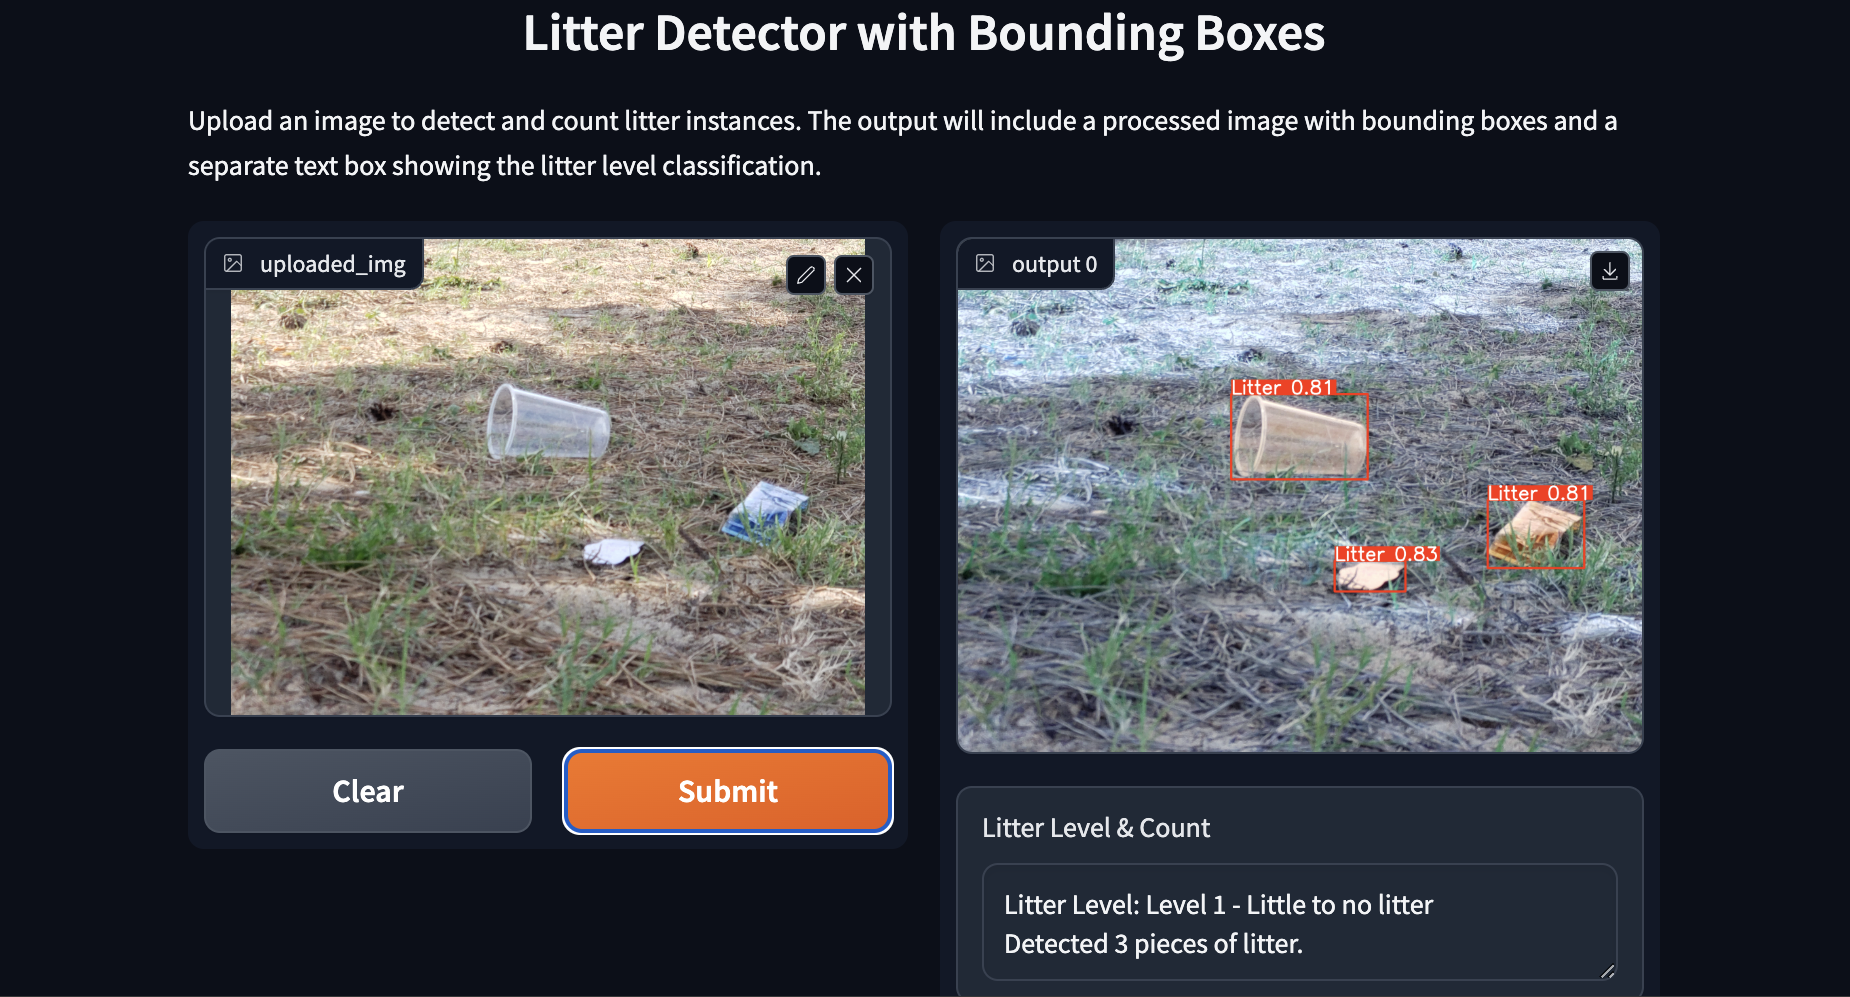

#Results and Evaluation
Our analysis revealed that litter is widespread across the City of Norfolk, with notable concentrations in southeastern areas—particularly along the Tidewater Drive/I-64 corridor and Little Creek Road. These hotspots were identified through geotagged image data and spatial clustering.

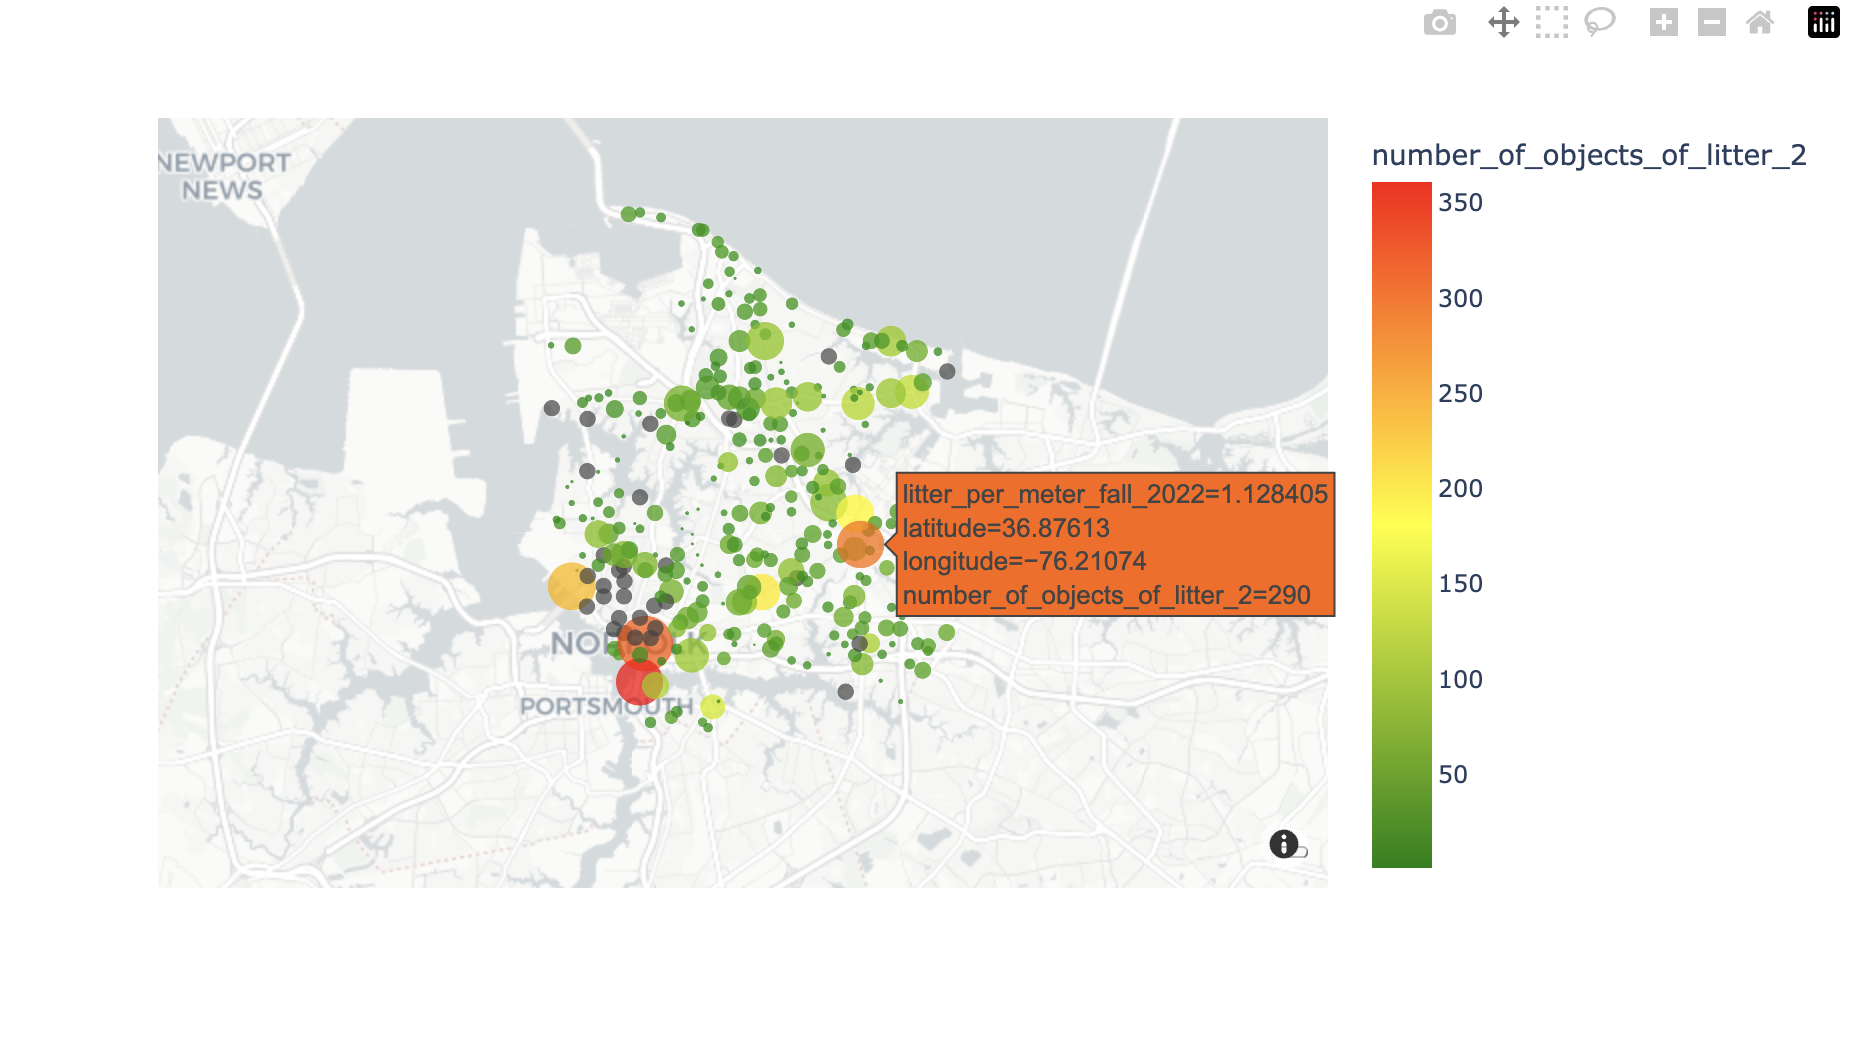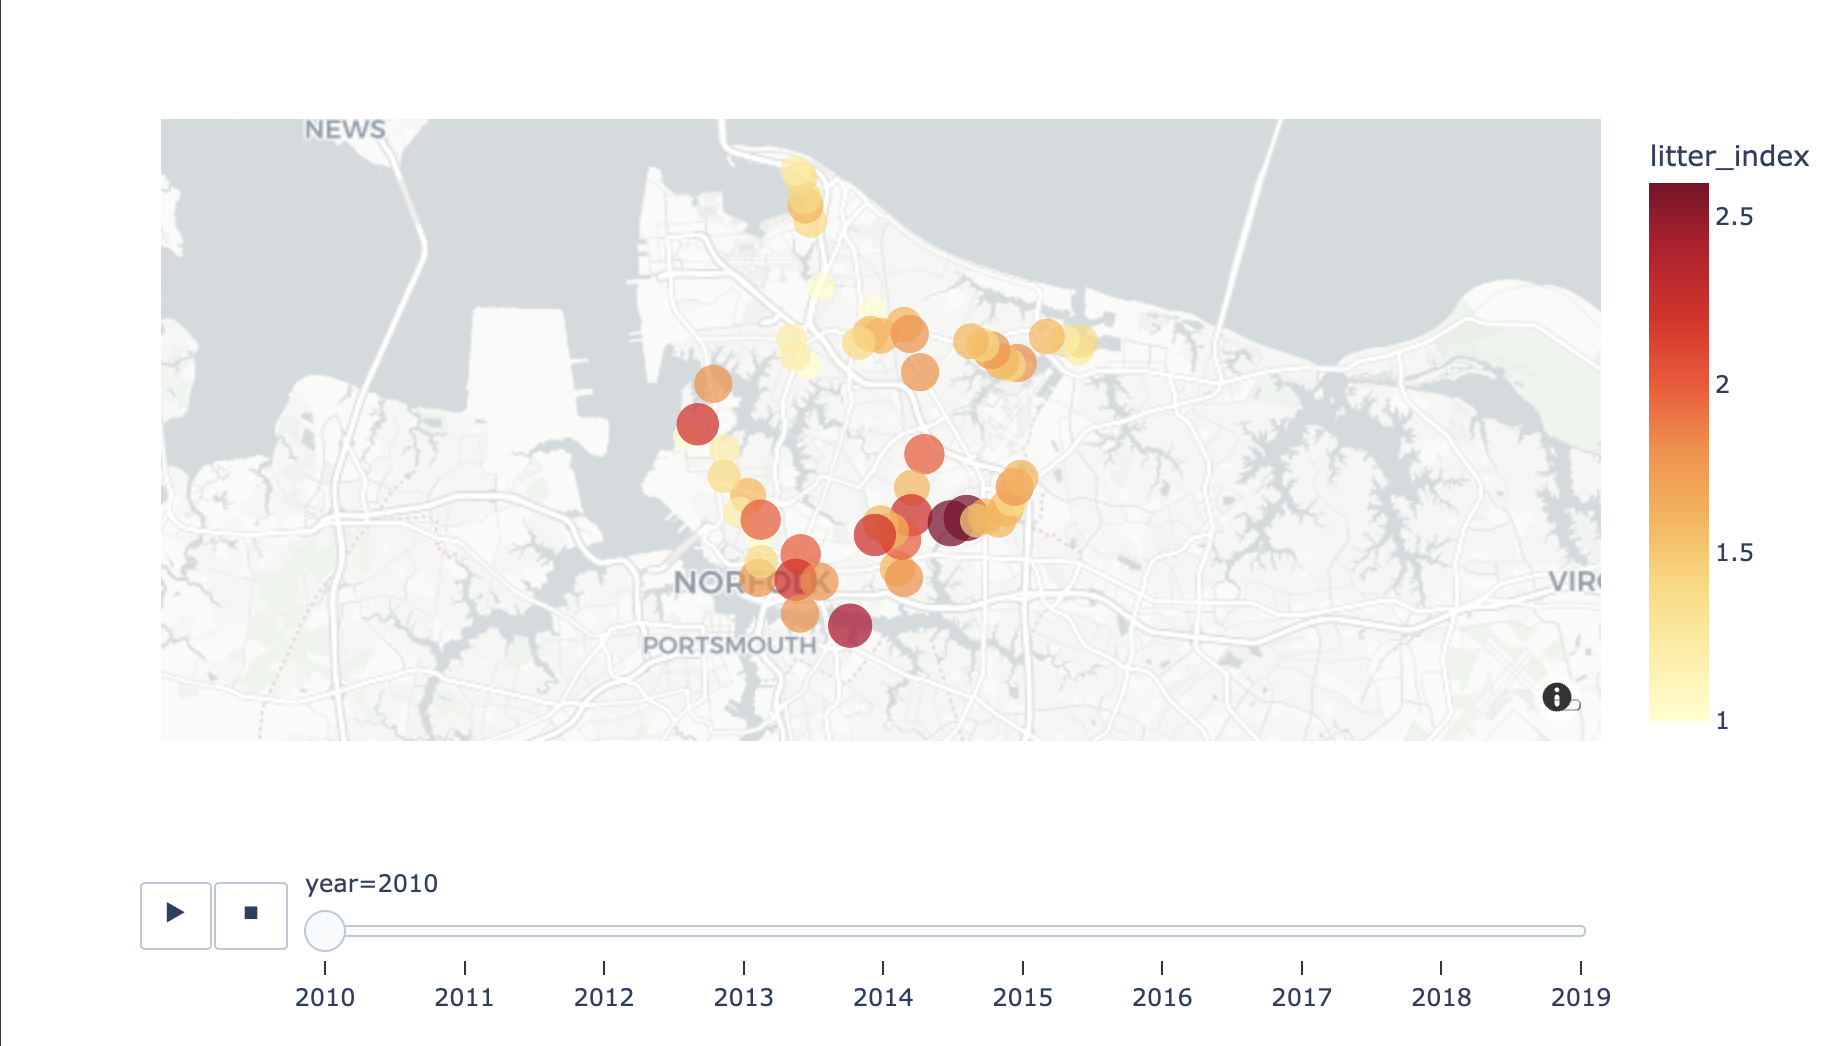
To address this, we developed a custom object detection model using the YOLO framework. The model was trained on a diverse dataset of labeled images capturing litter in a variety of environmental contexts, such as sidewalks, streets, and green spaces. The model currently achieves 84% precision and 64% recall, indicating strong accuracy in correctly identifying litter, with room to improve detection coverage.

A scalable implementation plan was developed to operationalize the model, which includes integrating the detection pipeline into existing city workflows, mapping litter trends over time, and exploring deployment on mobile or fixed-location cameras. This plan aims to support real-time monitoring, reduce the need for manual surveying, and inform targeted cleanup efforts by city agencies and community groups.

#Next Steps for Implementation

1. Prototype Data Collection and Batch Processing
(We’re here!)
Using insights from the exploratory data analysis (EDA), we’ll identify high-priority areas with significant litter presence to conduct field testing. This includes capturing new geotagged images and simulating what a scalable batch processing workflow might look like. The goal is to stress test the model under varying real-world conditions—lighting, angles, background noise—and assess its consistency. This phase lays the groundwork for automating litter detection at scale.

2. Transfer Process to a Local Platform
Currently, the model and pipeline are hosted in a cloud-based environment (Google Colab). The next step involves porting this codebase and setup to a local machine or server environment, ensuring it can run independently and consistently. This will allow for more secure, repeatable execution and reduce reliance on external resources, a critical requirement for real-time or large-scale deployments by city staff.

3. Present Results to Key Stakeholders and Discuss Next Steps
Once the local prototype is validated, we’ll prepare a results briefing tailored for city leadership, sustainability coordinators, and potential implementation partners. The presentation will cover model performance, cost-benefit of automation, and proposed areas for rollout. Stakeholder feedback will inform decisions about integration into existing workflows (e.g., city cleanup scheduling, community outreach) and identify opportunities for collaboration or funding support.

#Conclusion and Future Work
Through this project, I demonstrated that object detection models like YOLOv8 can be effectively trained to identify and quantify litter across urban environments, specifically within the City of Norfolk. The model achieved strong precision (84%) and reasonable recall (64%), proving its potential as a scalable tool for tracking litter accumulation. Combined with spatial analysis, this approach can help target cleanup efforts, reduce dependence on manual surveying, and support more data-informed resource allocation.

Looking ahead, this work can be expanded in several meaningful ways. A major next step is to enhance the model to not just detect the presence and quantity of litter, but also classify the type of litter—for example, separating plastic bottles, paper waste, food wrappers, or cigarette butts. This would open the door to more nuanced environmental analysis, such as understanding the composition of waste in different neighborhoods or identifying problem items that could be addressed through policy or education.

Additionally, integrating this model into a mobile or fixed-camera system with real-time geolocation would allow for continuous monitoring across the city. Future work could also explore citizen engagement by developing an app that lets residents contribute labeled images to improve the model over time while raising public awareness.

As a next step, I plan to explore the development of a mobile application that allows residents and city staff to contribute to the litter detection system. The app would enable users to capture and upload geotagged images of litter in their neighborhoods, which would then be processed by the detection model to assess both the quantity and type of litter present. In addition to crowdsourcing valuable data to improve model accuracy, the app could also provide real-time feedback, heatmaps, and trend insights to users—empowering communities to engage with cleanup efforts and city services. This citizen-driven approach would not only expand the dataset but also promote transparency and shared responsibility for public space cleanliness.

Overall, this project lays the foundation for an automated, data-driven litter indexing system that can evolve into a broader civic tool supporting sustainability and urban cleanliness efforts.

#References
Datasets
Litterati Litter per meter:
 https://data.norfolk.gov/dataset/Litter-Study-Litterati-Litter-Per-Meter/fq5y-c2yn/about_data

Litterati(Litter Study):
https://data.norfolk.gov/Environment/Litter-Study-Litterati-Litter/iz5u-2wb3/about_data

Litter index:
https://data.norfolk.gov/Environment/Litter-Index/nbz2-dgus/about_data

External Research

https://ktb.org/ktb-blog/the-economics-of-litter/

https://nobodytrashestennessee.com/what-is-the-cost-of-littering-explore-the-impacts-on-tennessee/

https://ecology.wa.gov/blog/april-2022/earth-day-2022-less-is-more

https://law.duke.edu/sites/default/files/clinics/environmental/Cost_of_Litter_in_NC.pdf

https://keeplibertybeautiful.org/litter-facts-you-cant-ignore.html



# Slides Used for Presentation
https://docs.google.com/presentation/d/1B7h0SKfsNIPJPmK75O2Ri_m94Ih3FjWQV1Pw2T1a4S4/edit?usp=sharing

#Link to Youtube Video
https://youtu.be/yvs9807QbZg